# 1. 导入相关库

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import pandas as pd
import random
import os
import seaborn as sns

import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm
from sklearn import metrics
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.nn import functional as F
from torch.utils.data import (
    DataLoader,
    Dataset,
)

from transformers import (
    BertModel,
    BertTokenizer,
)

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# 2. 导入数据并处理

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data/task2_train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      16670 non-null  int64 
 1   joke    16670 non-null  object
 2   label   16670 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 390.8+ KB


In [ ]:
data["label"].value_counts()

3    8624
1    4408
5    3638
Name: label, dtype: int64

In [ ]:
dict = {1: 0, 3: 1, 5: 2}
data["label"].replace(dict, inplace=True)
data["label"].value_counts()

1    8624
0    4408
2    3638
Name: label, dtype: int64

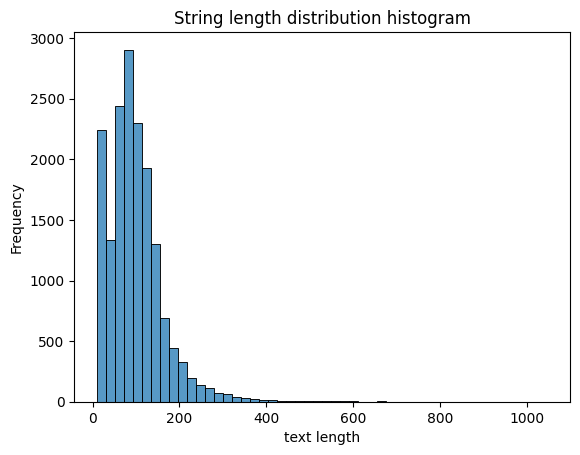

count    16670.000000
mean        99.006179
std         65.544911
min         10.000000
25%         58.000000
50%         89.000000
75%        127.000000
max       1048.000000
Name: joke, dtype: float64

In [ ]:
# 计算字符串长度并统计分布
length_counts = data["joke"].str.len()
# 绘制直方图
sns.histplot(length_counts, bins=50)
plt.xlabel("text length")
plt.ylabel("Frequency")
plt.title("String length distribution histogram")
plt.show()
# 字符串统计信息
length_counts.describe()

In [ ]:
# 只使用文本量较少的数据
filtered_data = data.loc[data["joke"].str.len() <= 200,'joke':'label'].reset_index(drop=True)
filtered_data["joke"].str.len().describe()

count    15651.000000
mean        87.649479
std         44.413837
min         10.000000
25%         55.000000
50%         85.000000
75%        119.000000
max        200.000000
Name: joke, dtype: float64

# 3. 导入模型

## 建立分词器

In [ ]:
# 下载的预训练文件路径
BERT_PATH = "/content/drive/MyDrive/LLM/Bert-Chinese"
# 加载分词器
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)

example_text = "我爱北京天安门。"
# 分词器测试
bert_input = tokenizer(
    example_text,
    padding="max_length",
    max_length=10,
    truncation=True,
    return_tensors="pt",
)  # pt表示返回tensor
print(bert_input)

{'input_ids': tensor([[ 101, 2769, 4263, 1266,  776, 1921, 2128, 7305,  511,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.joke = dataframe.joke
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.joke)

    def __getitem__(self, index):
        joke = str(self.joke[index])
        joke = " ".join(joke.split())

        inputs = self.tokenizer.encode_plus(
            joke,
            None,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.float),
        }

In [ ]:
train_size = 0.8
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8

train_dataset = filtered_data.sample(frac=train_size, random_state=648)
test_dataset = filtered_data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(filtered_data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (15651, 2)
TRAIN Dataset: (12521, 2)
TEST Dataset: (3130, 2)


In [ ]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}

test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## 建立模型

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained(BERT_PATH)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(
            ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False
        )
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output


model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# 4. 训练模型

In [ ]:
train_dataset["label"].value_counts()

1    6679
0    3082
2    2760
Name: label, dtype: int64

In [ ]:
EPOCHS = 3
LEARNING_RATE = 1e-04
GAMMA = 0.8

weight0 = len(train_dataset) / train_dataset["label"].value_counts()[0]
weight1 = len(train_dataset) / train_dataset["label"].value_counts()[1]
weight2 = len(train_dataset) / train_dataset["label"].value_counts()[2]
WEIGHT = torch.tensor([weight0, weight1, weight2],dtype=torch.float)
print("Weight:{}".format(WEIGHT))

Weight:tensor([4.0626, 1.8747, 4.5366])


In [ ]:
# 定义损失函数和优化器
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=WEIGHT).to(device)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [ ]:
def train(epoch):
    model.train()
    steps_count = 0
    for data in tqdm(training_loader):
        ids = data["ids"].to(device, dtype=torch.long)
        mask = data["mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        targets = data["targets"].to(device, dtype=torch.long)
        outputs = model(ids, mask, token_type_ids)

        loss = criterion(outputs, targets)
        steps_count += 1
        if steps_count % 100 == 0:
            print(f"Epoch: {epoch}, Loss:  {loss.item()}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch: {epoch}, Loss:  {loss.item()}")

In [27]:
for epoch in range(EPOCHS):
    train(epoch)

  0%|          | 0/783 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.987644612789154
Epoch: 0, Loss:  1.0947906970977783
Epoch: 0, Loss:  1.1145076751708984
Epoch: 0, Loss:  1.2590086460113525
Epoch: 0, Loss:  1.3056901693344116
Epoch: 0, Loss:  1.1088149547576904
Epoch: 0, Loss:  1.311653733253479
Epoch: 0, Loss:  1.2009615898132324


  0%|          | 0/783 [00:00<?, ?it/s]

Epoch: 1, Loss:  1.10762357711792
Epoch: 1, Loss:  1.20258629322052
Epoch: 1, Loss:  1.0595554113388062
Epoch: 1, Loss:  1.2825123071670532
Epoch: 1, Loss:  1.1668291091918945
Epoch: 1, Loss:  1.2812546491622925
Epoch: 1, Loss:  1.3481690883636475
Epoch: 1, Loss:  1.1322165727615356


  0%|          | 0/783 [00:00<?, ?it/s]

Epoch: 2, Loss:  1.1836227178573608
Epoch: 2, Loss:  1.1448726654052734
Epoch: 2, Loss:  1.083153486251831
Epoch: 2, Loss:  1.1504591703414917
Epoch: 2, Loss:  1.2174928188323975
Epoch: 2, Loss:  1.175803542137146
Epoch: 2, Loss:  0.9650375247001648
Epoch: 2, Loss:  1.1840150356292725


In [ ]:
#释放内存
#torch.cuda.empty_cache()

# 5. 评估模型

In [ ]:
#model = BERTClass()
#model.load_state_dict(torch.load(PATH))

In [28]:
def validation(model, data_loader):
    """使用模型预测给定数据集中每一条文本的分类标签

    Args:
        model: 使用的分类模型
        data_loader: 需要预测的数据

    Returns:
        fin_outputs: 预测标签
        fin_targets: 真实标签
    """
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for data in tqdm(data_loader):
            ids = data["ids"].to(device, dtype=torch.long)
            mask = data["mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            targets = data["targets"].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(outputs.detach().tolist())
            fin_targets.extend(targets.detach().tolist())
        fin_outputs = torch.tensor(fin_outputs)
        fin_outputs = torch.argmax(fin_outputs, dim=1)
    return fin_outputs, fin_targets

In [29]:
outputs, targets = validation(model, testing_loader)

  0%|          | 0/392 [00:00<?, ?it/s]

In [49]:
def evaluate(targets, outputs):
    conf = metrics.confusion_matrix(targets, outputs)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf,cmap=plt.cm.Blues, annot=True, fmt="d")
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix',fontsize=16)
    plt.show()
    print("Classification Report")
    print(metrics.classification_report(targets, outputs))

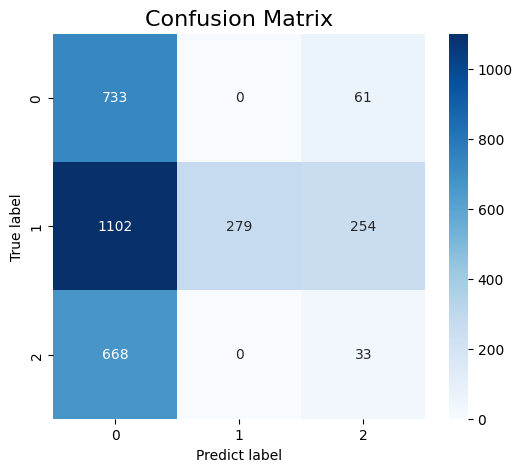

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.92      0.44       794
           1       1.00      0.17      0.29      1635
           2       0.09      0.05      0.06       701

    accuracy                           0.33      3130
   macro avg       0.46      0.38      0.27      3130
weighted avg       0.62      0.33      0.28      3130



In [50]:
evaluate(targets,outputs)

# 6. 保存模型

In [34]:
PATH='/content/drive/MyDrive/LLM/Bert-FT'
torch.save(model.state_dict(), PATH)